# Préparation du dataset

## Import du dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir

# Define photo image list 
path = "data/source/raw_folder_image/"
list_photos = [file for file in listdir(path)]
print('Find',len(list_photos),'photos.')

Find 1050 photos.


## Création des labels des photos à partir du nom des images

In [13]:
import pickle 
with open('data/cleaned/description_cleaned_spacy.pkl', 'rb') as f1:
    data = pickle.load(f1)

data = data[['image','cat_1']].rename(columns={"cat_1": "label_name"})
data.head()

,image,label_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing


In [14]:
data.apply(lambda x: type(x[0]))

image         <class 'str'>
label_name    <class 'str'>
dtype: object

In [21]:
from sklearn import preprocessing

# Definir la liste des catégories
list_labels = list(data.label_name.unique())

le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,baby care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,baby care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,baby care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,baby care,0


In [20]:
data.groupby("label_name").count()

,image,label
label_name,,
baby care,150,150
beauty and personal care,150,150
computers,150,150
home decor & festive needs,150,150
home furnishing,150,150
kitchen & dining,150,150
watches,150,150


## Affichage d'exemples d'images par label

home furnishing


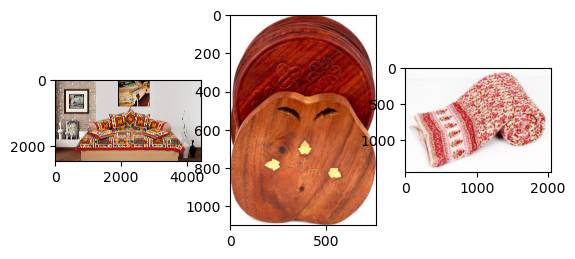

baby care


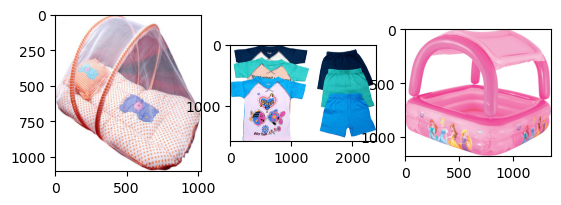

watches


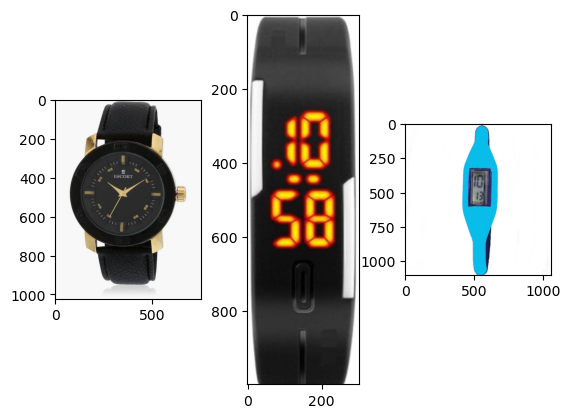

home decor & festive needs


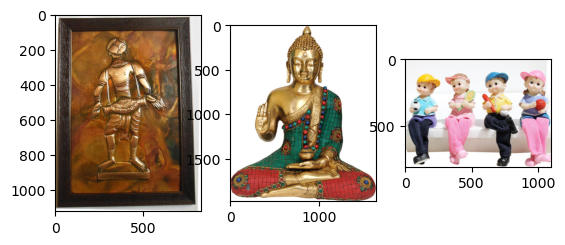

kitchen & dining


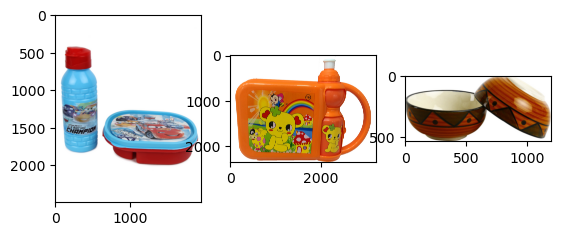

beauty and personal care


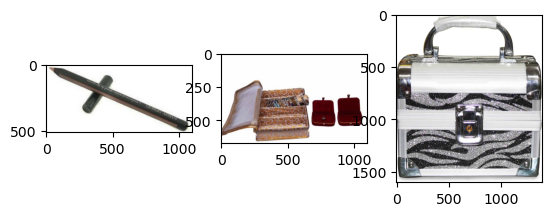

computers


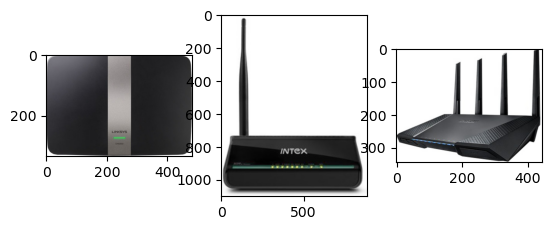

In [25]:
from matplotlib.image import imread

def list_fct(name) :
    """ Return """
    list_image_name = [data["image"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

for name in data.label_name.unique() :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

## Détermination et affichage des descripteurs SIFT

* L'image contient 4656 descripteurs
* Chaque descripteur est un vecteur de longueur 128

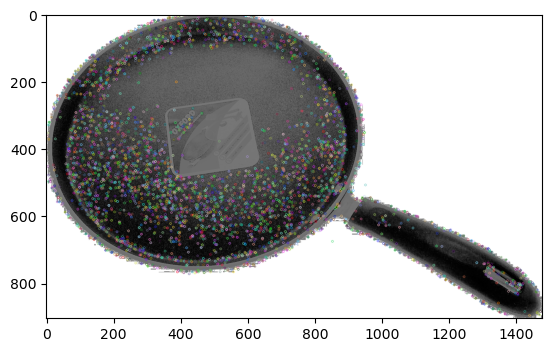

Descripteurs :  (4656, 128)

[[ 4.  2.  6. ...  5.  0.  0.]
 [96. 20.  0. ...  9.  2.  0.]
 [55. 16.  0. ...  0.  1.  0.]
 ...
 [12.  0.  0. ...  0.  0.  0.]
 [67. 19.  5. ...  0. 34. 13.]
 [ 0.  5. 27. ...  0.  0.  0.]]


In [27]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [28]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\eleor\AppData\Local\Temp\ipykernel_26440\1752111521.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           714.57 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [30]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


C:\Users\eleor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eleor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :            10.90 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [31]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            35.40 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [32]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [33]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

C:\Users\eleor\AppData\Local\Temp\ipykernel_26440\1491223451.py:2: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


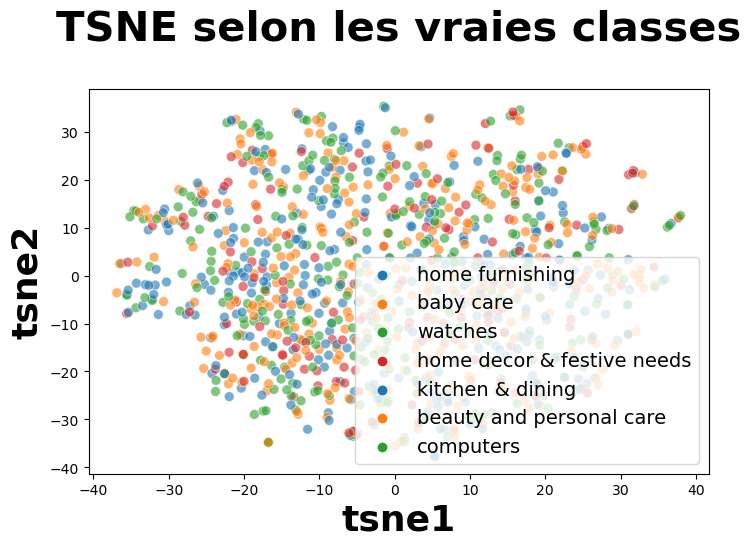

In [34]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [35]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


C:\Users\eleor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eleor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.15 reste faible

C:\Users\eleor\AppData\Local\Temp\ipykernel_26440\901863099.py:2: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


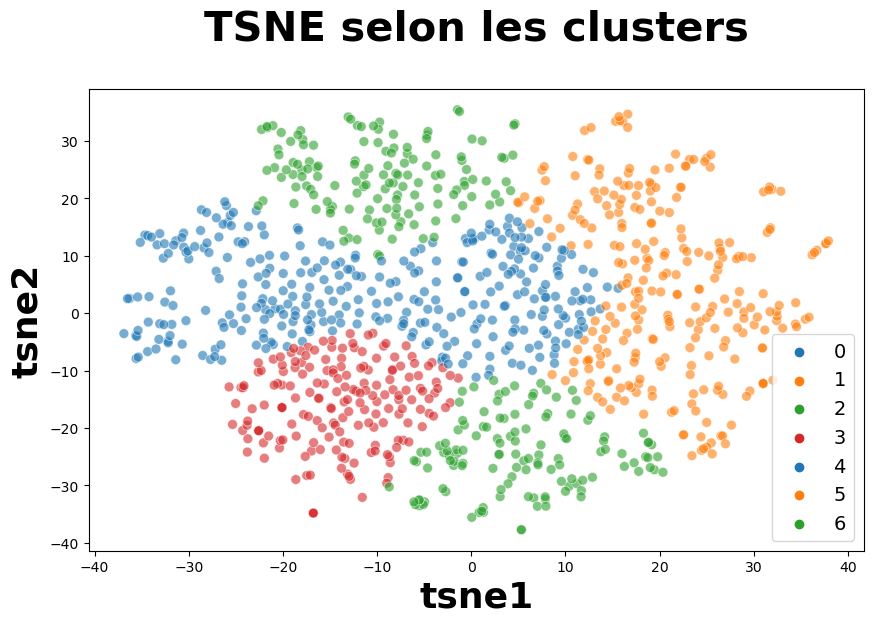

ARI :  0.00025534174579521624


In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [37]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    164
1    141
2    138
3    180
4    169
5    131
6    127
Name: class, dtype: int64

In [38]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[17 16 18 34 25 22 18]
 [22 22 23 23 24 20 16]
 [14 20 27 22 27 21 19]
 [22 20 15 26 24 26 17]
 [31 23 21 24 23 11 17]
 [31 24 21 21 23 12 18]
 [27 16 13 30 23 19 22]]


In [39]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3, 1, 2, 0]


IndexError: list index out of range

In [40]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

ValueError: Shape of passed values is (7, 7), indices imply (7, 4)